In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunxin/minico

1.13.2
2.2.4


Using TensorFlow backend.


In [2]:
import os
import numpy as np
from keras import models
from keras import layers
from keras.datasets import imdb
from keras import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_dir = '../datasets/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [4]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

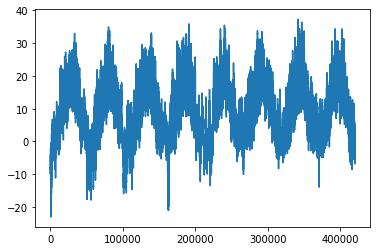

In [5]:
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

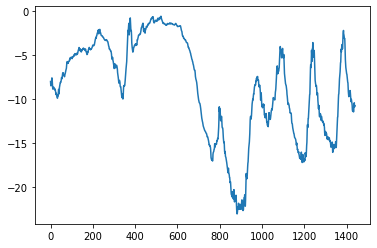

In [6]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [8]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [9]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### A common sense, non-machine learning baseline

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


### A basic machine learning approach

In [11]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 11s 21ms/step - loss: 1.3259 - val_loss: 0.7565
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.4716 - val_loss: 0.3784
Epoch 3/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3006 - val_loss: 0.3293
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2703 - val_loss: 0.3123
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2585 - val_loss: 0.3317
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2483 - val_loss: 0.3492
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2400 - val_loss: 0.3137
Epoch 8/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2346 - val_loss: 0.3224
Epoch 9/20
500/500 [==============================] - 8s 17ms/step - lo

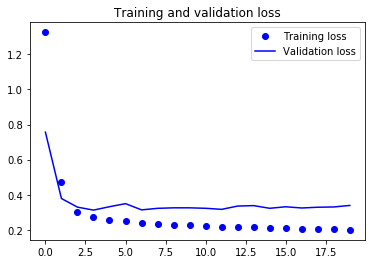

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### A first recurrent baseline

In [13]:
model = models.Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 122s 245ms/step - loss: 0.3023 - val_loss: 0.2738
Epoch 2/20
500/500 [==============================] - 122s 244ms/step - loss: 0.2850 - val_loss: 0.2664
Epoch 3/20
500/500 [==============================] - 123s 245ms/step - loss: 0.2757 - val_loss: 0.2674
Epoch 4/20
500/500 [==============================] - 122s 244ms/step - loss: 0.2737 - val_loss: 0.2660
Epoch 5/20
500/500 [==============================] - 122s 244ms/step - loss: 0.2681 - val_loss: 0.2660
Epoch 6/20
500/500 [==============================] - 122s 244ms/step - loss: 0.2629 - val_loss: 0.2673
Epoch 7/20
500/500 [==============================] - 123s 246ms/step - loss: 0.2594 - val_loss: 0.2655
Epoch 8/20
500/500 [==============================] - 122s 245ms/step - loss: 0.2543 - val_loss: 0.2744
Epoch 9/20
500/500 [==============================] - 122s 245ms/step - loss: 0.2513 - val_loss: 0.2714
Epoch 10/20
500/500 [==============================] - 122s 245m

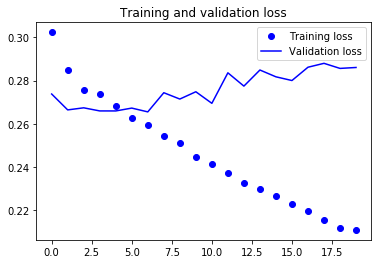

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Using recurrent dropout to fight overfitting

In [15]:
model = models.Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/40
500/500 [==============================] - 144s 288ms/step - loss: 0.3338 - val_loss: 0.2736
Epoch 2/40
500/500 [==============================] - 144s 288ms/step - loss: 0.3133 - val_loss: 0.2711
Epoch 3/40
500/500 [==============================] - 144s 287ms/step - loss: 0.3066 - val_loss: 0.2747
Epoch 4/40
500/500 [==============================] - 146s 292ms/step - loss: 0.3020 - val_loss: 0.2682
Epoch 5/40
500/500 [==============================] - 147s 294ms/step - loss: 0.3000 - val_loss: 0.2684
Epoch 6/40
500/500 [==============================] - 148s 296ms/step - loss: 0.2979 - val_loss: 0.2732
Epoch 7/40
500/500 [==============================] - 147s 295ms/step - loss: 0.2955 - val_loss: 0.2689
Epoch 8/40
500/500 [==============================] - 147s 294ms/step - loss: 0.2940 - val_loss: 0.2694
Epoch 9/40
500/500 [==============================] -

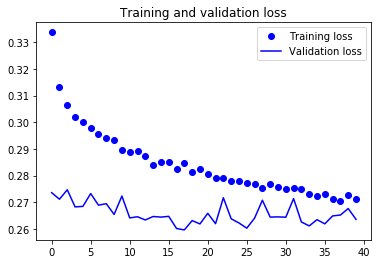

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Stacking recurrent layers

In [17]:
model = models.Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 283s 565ms/step - loss: 0.3360 - val_loss: 0.2803
Epoch 2/40
500/500 [==============================] - 266s 531ms/step - loss: 0.3137 - val_loss: 0.2725
Epoch 3/40
500/500 [==============================] - 266s 532ms/step - loss: 0.3077 - val_loss: 0.2744
Epoch 4/40
500/500 [==============================] - 266s 532ms/step - loss: 0.3016 - val_loss: 0.2735
Epoch 5/40
500/500 [==============================] - 265s 529ms/step - loss: 0.2988 - val_loss: 0.2650
Epoch 6/40
500/500 [==============================] - 265s 531ms/step - loss: 0.2958 - val_loss: 0.2670
Epoch 7/40
500/500 [==============================] - 266s 531ms/step - loss: 0.2942 - val_loss: 0.2689
Epoch 8/40
500/500 [==============================] - 271s 541ms/step - loss: 0.2898 - val_loss: 0.2707
Epoch 9/40
500/500 [==============================] - 277s 554ms/step - loss: 0.2877 - val_loss: 0.2702
Epoch 10/40
500/500 [==============================] - 285s 570m

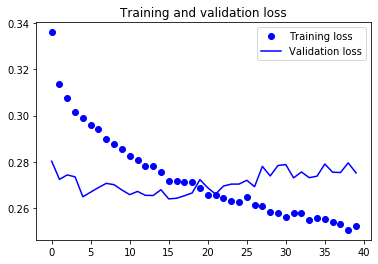

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Using bidirectional RNNs

In [21]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

model = models.Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 127s 255ms/step - loss: 0.4754 - val_loss: 0.4804
Epoch 2/20
500/500 [==============================] - 129s 259ms/step - loss: 0.4506 - val_loss: 0.4908
Epoch 3/20
500/500 [==============================] - 129s 258ms/step - loss: 0.4081 - val_loss: 0.4819
Epoch 4/20
500/500 [==============================] - 130s 259ms/step - loss: 0.3603 - val_loss: 0.4583
Epoch 5/20
500/500 [==============================] - 130s 259ms/step - loss: 0.3354 - val_loss: 0.4761
Epoch 6/20
500/500 [==============================] - 129s 258ms/step - loss: 0.3205 - val_loss: 0.4629
Epoch 7/20
500/500 [==============================] - 130s 259ms/step - loss: 0.3068 - val_loss: 0.4696
Epoch 8/20
500/500 [==============================] - 130s 260ms/step - loss: 0.2955 - val_loss: 0.4775
Epoch 9/20
500/500 [==============================] - 130s 260ms/step - loss: 0.2859 - val_loss: 0.4773
Epoch 10/20
500/500 [==============================] - 130s 260m

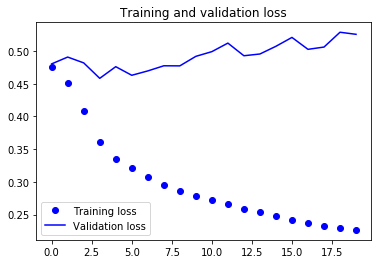

In [22]:
# reverse the inputs -> worse results on jena dataset
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
# reverse the inputs -> similar results on imdb dataset
max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

model = models.Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 91s 5ms/step - loss: 0.4912 - acc: 0.7658 - val_loss: 0.3669 - val_acc: 0.8538
Epoch 2/10
20000/20000 [==============================] - 90s 4ms/step - loss: 0.3209 - acc: 0.8756 - val_loss: 0.3174 - val_acc: 0.8764
Epoch 3/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.2584 - acc: 0.9030 - val_loss: 0.3720 - val_acc: 0.8396
Epoch 4/10
20000/20000 [==============================] - 83s 4ms/step - loss: 0.2185 - acc: 0.9224 - val_loss: 0.3996 - val_acc: 0.8766
Epoch 5/10
20000/20000 [==============================] - 82s 4ms/step - loss: 0.1971 - acc: 0.9318 - val_loss: 0.3756 - val_acc: 0.8766
Epoch 6/10
20000/20000 [==============================] - 82s 4ms/step - loss: 0.1762 - acc: 0.9378 - val_loss: 0.3500 - val_acc: 0.8772
Epoch 7/10
20000/20000 [==============================] - 82s 4ms/step - loss: 0.1569 - acc: 0.9452 - val_loss: 0.4471 - val_acc:

In [24]:
# Bidirectional RNN -> better results on imdb dataset
model = models.Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 154s 8ms/step - loss: 0.5593 - acc: 0.7171 - val_loss: 0.4017 - val_acc: 0.8390
Epoch 2/10
20000/20000 [==============================] - 154s 8ms/step - loss: 0.3343 - acc: 0.8713 - val_loss: 0.3337 - val_acc: 0.8804
Epoch 3/10
20000/20000 [==============================] - 153s 8ms/step - loss: 0.2625 - acc: 0.9035 - val_loss: 0.4071 - val_acc: 0.8736
Epoch 4/10
20000/20000 [==============================] - 153s 8ms/step - loss: 0.2343 - acc: 0.9186 - val_loss: 0.3245 - val_acc: 0.8738
Epoch 5/10
20000/20000 [==============================] - 154s 8ms/step - loss: 0.2071 - acc: 0.9268 - val_loss: 0.3813 - val_acc: 0.8796
Epoch 6/10
20000/20000 [==============================] - 154s 8ms/step - loss: 0.1833 - acc: 0.9335 - val_loss: 0.3882 - val_acc: 0.8772
Epoch 7/10
20000/20000 [==============================] - 153s 8ms/step - loss: 0.1709 - acc: 0.9411 - val_loss: 0.3654 - v

In [25]:
# Bidirectional RNN -> similar results on jena dataset
model = models.Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 247s 494ms/step - loss: 0.2930 - val_loss: 0.2739
Epoch 2/40
500/500 [==============================] - 244s 488ms/step - loss: 0.2743 - val_loss: 0.2720
Epoch 3/40
500/500 [==============================] - 244s 489ms/step - loss: 0.2666 - val_loss: 0.2703
Epoch 4/40
500/500 [==============================] - 244s 488ms/step - loss: 0.2628 - val_loss: 0.2718
Epoch 5/40
500/500 [==============================] - 245s 490ms/step - loss: 0.2552 - val_loss: 0.2729
Epoch 6/40
500/500 [==============================] - 240s 479ms/step - loss: 0.2483 - val_loss: 0.2722
Epoch 7/40
500/500 [==============================] - 225s 449ms/step - loss: 0.2443 - val_loss: 0.2814
Epoch 8/40
500/500 [==============================] - 223s 445ms/step - loss: 0.2388 - val_loss: 0.2835
Epoch 9/40
500/500 [==============================] - 229s 459ms/step - loss: 0.2325 - val_loss: 0.2825
Epoch 10/40
500/500 [==============================] - 228s 455m